In [1]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scripts.afilter as afilter
import scripts.sigutil as util

## Non adaptive, non iterative approach

We compute the optimal filter $\bold{f}$ by naively solving the normal equations $R_X \bold{f} = \bold{r_{DX}}$. This is far from optimal because it is a slow method and it is not adaptive.

#### Read audio files

In [2]:
# Normalization by 2^15 - 1 is necessary
fs, d, d_norm = util.read_normalized('data/2_RecStatic.wav')
_, x, x_norm = util.read_normalized('data/2_Sig.wav')

In [3]:
print("Source signal corrupted by ambient noise:")
IPython.display.Audio(d, rate=fs)


Source signal corrupted by ambient noise:


In [4]:
print("Ambient noise correlated to that of the source signal")
IPython.display.Audio(x, rate=fs)

Ambient noise correlated to that of the source signal


### Compute correlation matrices and optimal filter

In [5]:
K = 800  # Number of taps
f, reconstructed = afilter.fixed_optimal_lms(x_norm, d_norm, K)

### Apply filter, plot results

In [6]:
print("Filtered signal (= error signal)")
IPython.display.Audio(reconstructed, rate=fs)

Filtered signal (= error signal)


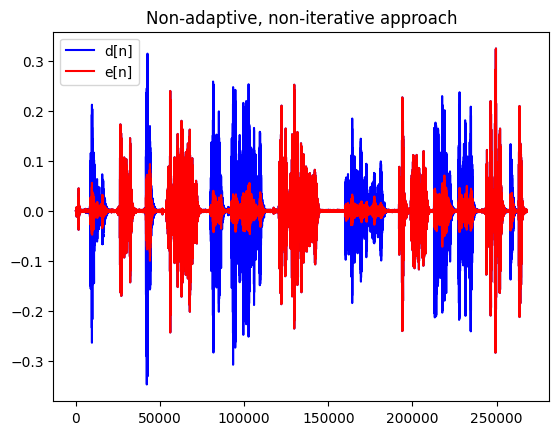

In [7]:
plt.title('Non-adaptive, non-iterative approach')
plt.plot(d_norm, color='blue', label='d[n]')
plt.plot(reconstructed, color='red', label='e[n]')
plt.legend()

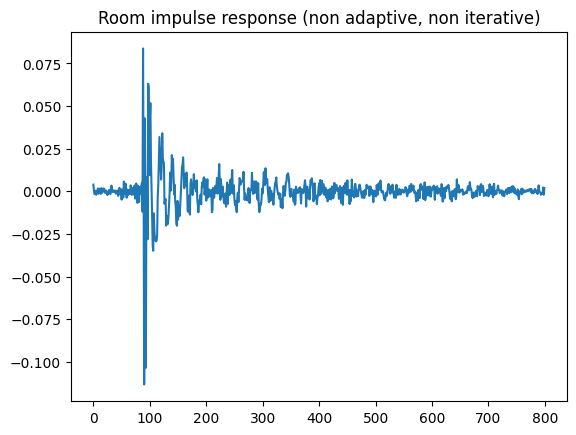

In [8]:
plt.title('Room impulse response (non adaptive, non iterative)')
plt.plot(f)

### Non adaptive, iterative method

Instead of solving the normal equations directly, we solve them using an iteration. The optimal filter is given by the iteration $\bold{f}^{(i+1)} = \bold{f}^{(i)} + \mu \bold{p}$ where $\bold{p}$ is an update direction and $0 < \mu < \frac{2}{\lambda_{\text{max}}}$ is the step size. This iteration approximates the solution of $R_X \bold{f} = \bold{r_{DX}}$. This method is not fundamentally different than the previous one.

In [9]:
# Normalization by 2^15 - 1 is necessary
fs, d, d_norm = util.read_normalized('data/2_RecStatic.wav')  # read d[n]
_, x, x_norm = util.read_normalized('data/2_Sig.wav')  # read x[n]

#### Compute step size

In [10]:
K = 800  # number of taps
N_it = 500  # number of iterations

f_it, reconstructed = afilter.fixed_iterative_lms(x_norm, d_norm, K, N_it)

### Apply filter, plot results

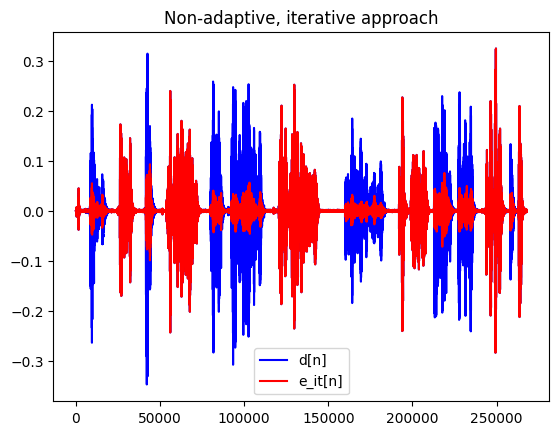

In [11]:
plt.title('Non-adaptive, iterative approach')
plt.plot(d_norm, color='blue', label='d[n]')
plt.plot(reconstructed, color='red', label='e_it[n]')
plt.legend()

We plot the impulse response of the iterative method and the difference $f-f_{it}$ which is expected to be close to zero (i.e the iterative method and the exact solution of the normal equations should produce identical results).

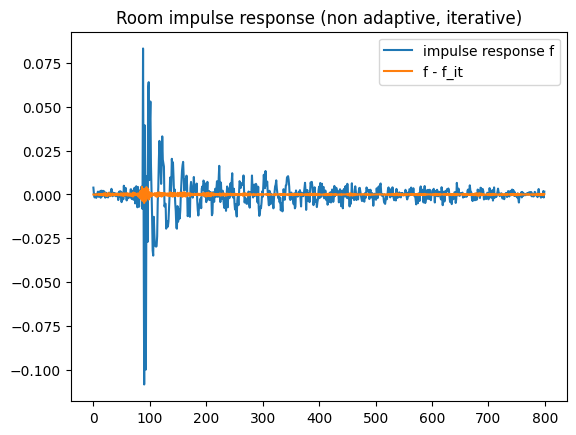

In [12]:
# TODO: plot with meaningful x axis (avec des secondes par exemple, vu qu'on a acces a la sampling freq)
plt.title('Room impulse response (non adaptive, iterative)')
plt.plot(f_it, label='impulse response f')
plt.plot(f - f_it, label='f - f_it')
plt.legend()

## Adaptive Least Mean Squares (LMS)

This method uses the LMS algorithm, which iteratively computes $\bold{f}_{n+1} = \bold{f}_n + \mu \bold{x}_n e_n$, where $e_n = d_n - y_n$. It is much faster than the previous naive method and can be used to compute $\bold{f}_n$ on the fly.

In [13]:
fs, d, d_norm = util.read_normalized('data/2_RecChanging.wav')  # read d[n]
_, x, x_norm = util.read_normalized('data/2_Sig.wav')  # read x[n]

In [14]:
# Choose 0 < mu < 2/lambdaMax. Problem: cannot really estimate lambda_max at this stage
mu = 0.03  # choose mu intuitively

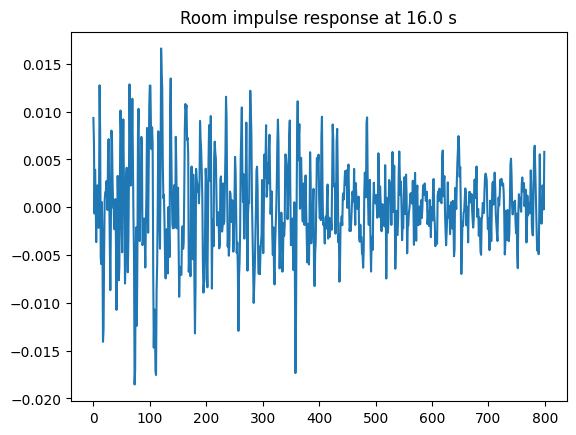

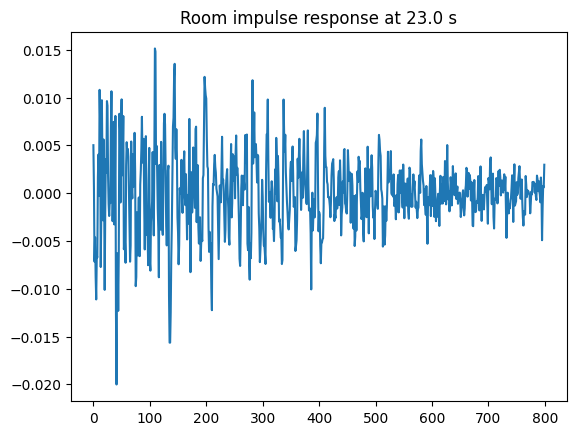

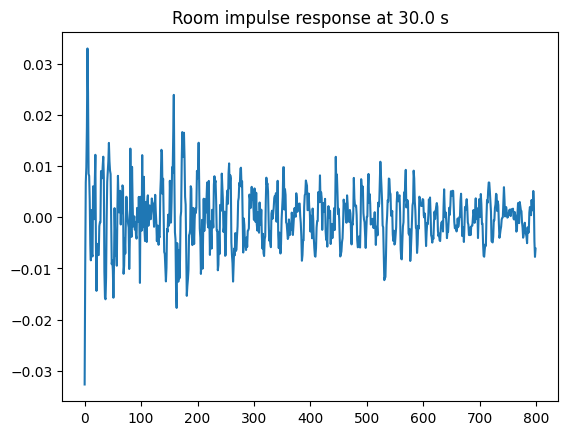

In [15]:
# Apply the iteration (cf other notebooks)
K = 800  # number of taps
N_it = 20  # number of iterations

def plot_adaptive(i, sig):
    if (i - 2*fs) % (7*fs) == 0 and i > 10*fs:
        plt.title(f'Room impulse response at {i/fs} s')
        plt.plot(sig)
        plt.show()

f_ad, e_ad = afilter.adaptive_iterative_lms(x_norm, d_norm, K, N_it, mu, plot_adaptive)

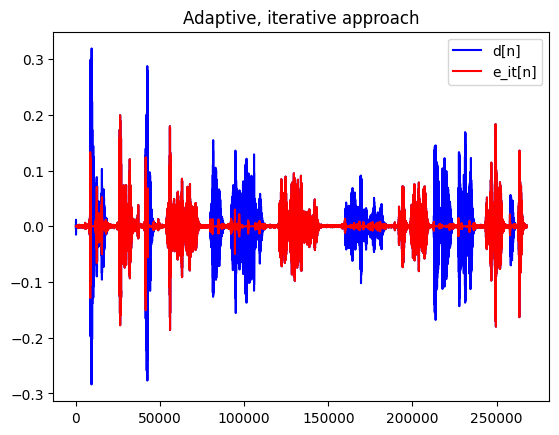

In [16]:
plt.title('Adaptive, iterative approach')
plt.plot(d_norm, color='blue', label='d[n]')
plt.plot(e_ad, color='red', label='e_it[n]')
plt.legend()

In [17]:
IPython.display.Audio(e_ad, rate=fs)

In [18]:
IPython.display.Audio(d, rate=fs)

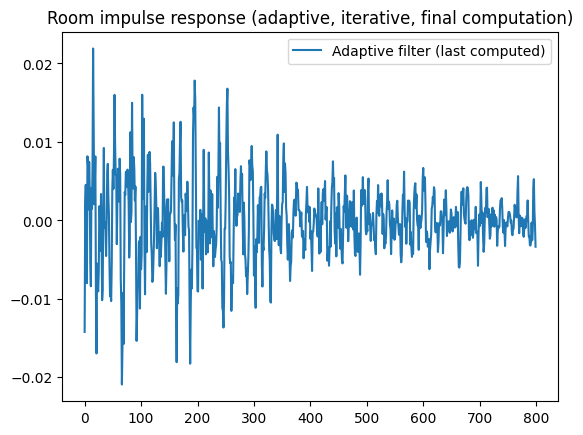

In [19]:
plt.title('Room impulse response (adaptive, iterative, final computation)')
plt.plot(f_ad, label='Adaptive filter (last computed)')
#plt.plot(f, label='Non adaptive non iterative optimal filter', alpha=0.5)
plt.legend()